***Nisa Aprilia M.***

***FTDS #004***

**Phase 2, Milestone 2: Natural Languange Processing**

# I. INTRODUCTION

**1) PROBLEM**

A restaurant chain has just published a new portal/website for customers to access features like menu, event update, and even to write customer's experience, in order to improve customer satisfaction. To maximize the effectiveness of this portal, the restaurant needs a filter to determine whether the review submitted by customers are good/bad experience. 

**2) DATASET**

Title: Restaurant Customer Reviews

Source: https://www.kaggle.com/vigneshwarsofficial/reviews

Dataset Brief Information: The dataset consists of 1000 rows and 2 columns. Review Column consist of customer reviews and like column consist of 0 (negative/bad review) and 1 (positive/good review).

**3) OBJECTIVES**

Build a model to detect whether the review submitted by customers are classified as positive / negative review. 

# II. IMPORT LIBRARY 

In [12]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Input, Embedding, Dense
from keras.callbacks import EarlyStopping
import random
from sklearn.metrics import classification_report 
import seaborn as sns
from textblob import Word

import re
import string
from wordcloud import WordCloud

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# III. LOAD DATA

In [13]:
df = pd.read_csv(r"C:\Users\nisam\Downloads\Restaurant_Reviews.tsv", delimiter="\t")
df

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [14]:
df.shape

(1000, 2)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


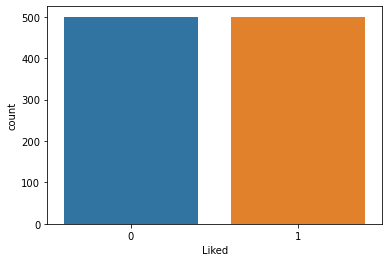

In [16]:
sns.countplot(x='Liked', data=df);

***Label distribution is balanced.***

# IV. DATA CLEANING

**Rename column "Liked" to be "Label":**

In [17]:
df.rename(columns={'Liked': 'Label'}, inplace=True)

**Take a look at some reviews from the dataset:**

In [18]:
for index,text in enumerate(df['Review'][100:105]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 Our server was fantastic and when he found out the wife loves roasted garlic and bone marrow, he added extra to our meal and another marrow to go!
Review 2:
 The only good thing was our waiter, he was very helpful and kept the bloddy mary's coming.
Review 3:
 Best Buffet in town, for the price you cannot beat it.
Review 4:
 I LOVED their mussels cooked in this wine reduction, the duck was tender, and their potato dishes were delicious.
Review 5:
 This is one of the better buffets that I have been to.


***Summary:***

***- There is an example of a word in all capital, in review 4: "LOVED", and there is possibility something like this will be found on other reviews as well. For model to train better, we need to lowercase all words.***

***- There are many punctuation marks, such as exclamation point, comma, and period. Therefore we need to remove punctuations.***



# Casefolding

**1) Lowercase words**

In [19]:
df['Review_Cleaned'] = df['Review'].apply(lambda x: x.lower())
df.head()

,Review,Label,Review_Cleaned
0,Wow... Loved this place.,1,wow... loved this place.
1,Crust is not good.,0,crust is not good.
2,Not tasty and the texture was just nasty.,0,not tasty and the texture was just nasty.
3,Stopped by during the late May bank holiday of...,1,stopped by during the late may bank holiday of...
4,The selection on the menu was great and so wer...,1,the selection on the menu was great and so wer...


**2) Remove Punctuations**  

In [20]:
df['Review_Cleaned']=df['Review_Cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df.head()

,Review,Label,Review_Cleaned
0,Wow... Loved this place.,1,wow loved this place
1,Crust is not good.,0,crust is not good
2,Not tasty and the texture was just nasty.,0,not tasty and the texture was just nasty
3,Stopped by during the late May bank holiday of...,1,stopped by during the late may bank holiday of...
4,The selection on the menu was great and so wer...,1,the selection on the menu was great and so wer...


# V. EXPLORATORY DATA ANALYSIS 

**Length of reviews:**

In [21]:
df["Length"]= df["Review"].apply(len) 
df.head()

,Review,Label,Review_Cleaned,Length
0,Wow... Loved this place.,1,wow loved this place,24
1,Crust is not good.,0,crust is not good,18
2,Not tasty and the texture was just nasty.,0,not tasty and the texture was just nasty,41
3,Stopped by during the late May bank holiday of...,1,stopped by during the late may bank holiday of...,87
4,The selection on the menu was great and so wer...,1,the selection on the menu was great and so wer...,59


In [22]:
import cufflinks as cf
import plotly.io as pio
pio.renderers.default = "svg"
cf.go_offline()
fig=df["Length"].iplot(kind="histogram") 

***Most words length are between 20-64, the highest is in range 20-24: 78***

In [847]:
df["Length"].describe()

count    1000.000000
mean       58.315000
std        32.360052
min        11.000000
25%        33.000000
50%        51.000000
75%        80.000000
max       149.000000
Name: Length, dtype: float64

**Most common words in each classes in wordclouds:**

In [848]:
# seperate data for each class 
positive = df[df["Label"] == 1]
negative = df[df["Label"] == 0]

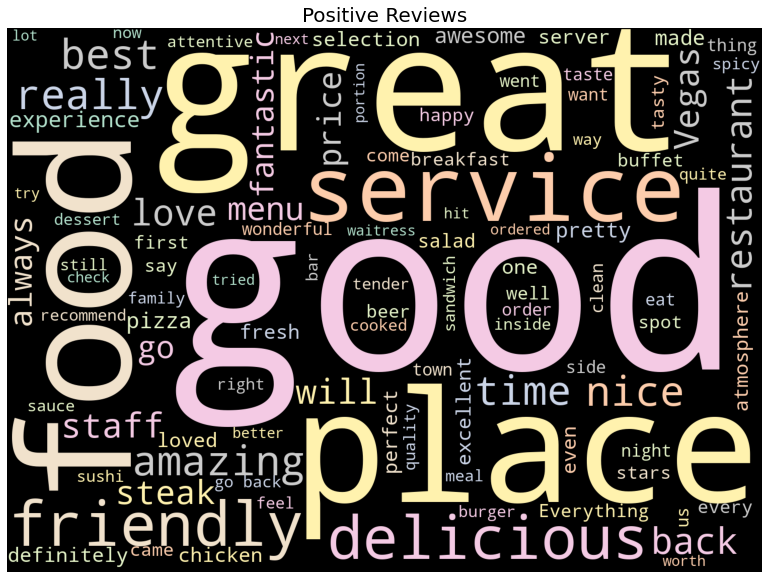

In [849]:
# wordcloud visualization for positive class 
plt.subplots(figsize=(20,10))
wordcloud = WordCloud(background_color='black', max_words = 100, width=1500, height=1080).generate(" ".join(positive.Review))
plt.title("Positive Reviews", fontsize=20)
plt.imshow(wordcloud.recolor( colormap= 'Pastel2'))
plt.axis('off')
plt.show()

***Most common words in positive class are: Good, Great, Friendly, Nice, Delicious, Best, Amazing, etc.***

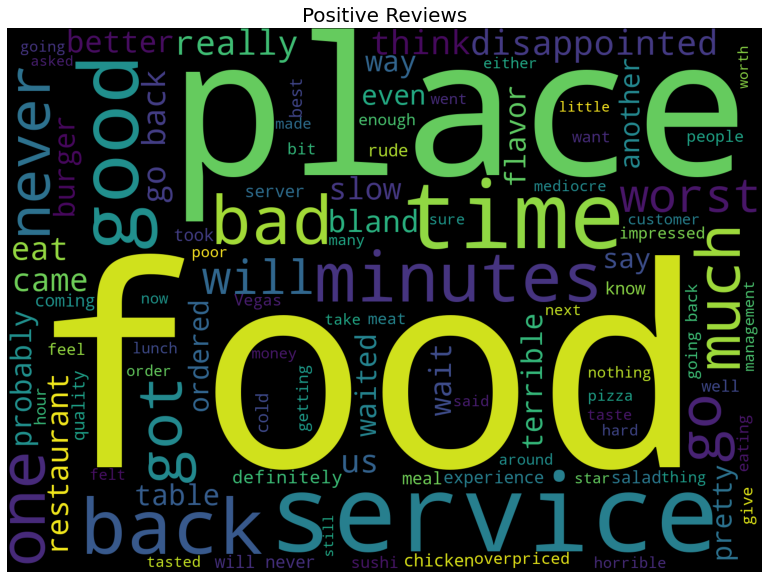

In [850]:
# wordcloud visualization for negative class 
plt.subplots(figsize=(20,10))
wordcloud = WordCloud(background_color='black', max_words = 100, width=1500, height=1080).generate(" ".join(negative.Review))
plt.title("Positive Reviews", fontsize=20)
plt.imshow(wordcloud.recolor(colormap= 'viridis'))
plt.axis('off')
plt.show()

***Most common words in negative class are: Food, Place, Time, Service, Never, Worst, Bad, Terrible, etc.***

# VI. DATA PREPROCESSING 

**Drop column "Review" and only use "Review_Cleaned" on the dataset for model building**

In [851]:
df = df.drop(columns=['Review', 'Length'])
df = df[['Review_Cleaned', 'Label']]
df.head()

,Review_Cleaned,Label
0,wow loved this place,1
1,crust is not good,0
2,not tasty and the texture was just nasty,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


**Seperate data between train and test:**

In [852]:
# seperate data train and data test
train_df, test_df = train_test_split(df, test_size=0.2)

X_train, y_train = train_df.Review_Cleaned, train_df.Label
X_test, y_test = test_df.Review_Cleaned, test_df.Label

In [853]:
X_train, y_train = train_df.Review_Cleaned, train_df.Label
X_test, y_test = test_df.Review_Cleaned, test_df.Label

def prepare_target(y_train, y_test):
    y_train_enc = to_categorical(y_train)
    y_test_enc = to_categorical(y_test)
    return y_train_enc, y_test_enc

y_train, y_test = prepare_target(y_train, y_test)

In [854]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

**Splitting Data:**

In [855]:
train_sent, val_sent, train_labels, val_labels = train_test_split(X_train.to_numpy(),
                                                                   y_train,
                                                                   test_size=0.2)

**Make sure the classification of some samples in data train:**

In [856]:
train_sent[:10], train_labels[:10]

(array(['service was fine and the waitress was friendly',
        'definitely not worth the 3 i paid',
        'but now i was completely grossed out',
        'owners are really great people',
        'all of the tapas dishes were delicious',
        'they have great dinners',
        'great subway in fact its so good when you come here every other subway will not meet your expectations',
        'the price is reasonable and the service is great',
        'i ate there twice on my last visit and especially enjoyed the salmon salad',
        'but i dont like it'], dtype=object),
 array([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]], dtype=float32))

***Result: classification of all samples are correct.***

**Tokenize words:**

In [857]:
# set max length of words for input using average value of 'length' we have previously explored in EDA
avg_len_words = 58

In [858]:
# setup text vectorization
max_vocab_length = 5000
max_length = avg_len_words

text_vect = TextVectorization(max_tokens=None,
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_length)

In [859]:
# text vectorization
text_vect.adapt(train_sent)

In [860]:
# vectorization testing with new input 
sample_review = "Their food was excellent, I enjoyed my visit and would like to visit again someday"
text_vect([sample_review])

<tf.Tensor: shape=(1, 58), dtype=int64, numpy=
array([[ 50,  12,   5, 167,   4, 380,  23, 249,   3,  65,  34,   7, 249,
         77,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]], dtype=int64)>

In [861]:
# vectorization testing with existing input from data train  
random_review = random.choice(train_sent)
print(f"Original Text : {random_review}\n")
text_vect([random_review])

Original Text : similarly the delivery man did not say a word of apology when our food was 45 minutes late



<tf.Tensor: shape=(1, 58), dtype=int64, numpy=
array([[ 831,    2, 1379, 1091,   70,   14,   91,    6,  418,   10, 1560,
          71,   40,   12,    5, 1589,   73,  525,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]], dtype=int64)>

**Layer Embedding**

In [862]:
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length)

embedding

In [863]:
random_review = random.choice(train_sent)
print(f"Original Text : {random_review}\n")

sample_embedded = embedding(text_vect([random_review]))
sample_embedded.shape

Original Text : great food



TensorShape([1, 58, 128])

# VII. MODEL BUILDING 

**MODEL #1: FULLY CONNECTED NN WITH 3 HIDDEN LAYERS**

**MODEL DEFINITION**

In [864]:
np.random.seed(42)
tf.random.set_seed(42)

In [865]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vect(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
dense1 = Dense(5,activation='relu')(x)
dense2 = Dense(5,activation='relu')(dense1)
dense3 = Dense(5,activation='relu')(dense2)
outputs = layers.Dense(2, activation='sigmoid')(dense3)
model1 = tf.keras.Model(inputs, outputs, name='model_nlp_fc')

**MODEL COMPILE**

In [866]:
model1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [867]:
# set early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

**MODEL TRAINING**

In [868]:
model1_hist = model1.fit(train_sent,
                           train_labels,
                           epochs=50,
                           validation_data=(val_sent, val_labels),
                           callbacks=[es])

Epoch 1/50
20/20 [==============================] - 1s 17ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6935 - val_accuracy: 0.4625
Epoch 2/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6930 - accuracy: 0.5156 - val_loss: 0.6937 - val_accuracy: 0.4625
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6925 - accuracy: 0.5156 - val_loss: 0.6940 - val_accuracy: 0.4625
Epoch 4/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6913 - accuracy: 0.5156 - val_loss: 0.6936 - val_accuracy: 0.4625
Epoch 5/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6888 - accuracy: 0.5156 - val_loss: 0.6926 - val_accuracy: 0.4625
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6842 - accuracy: 0.5156 - val_loss: 0.6905 - val_accuracy: 0.4625
Epoch 7/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6760 - accuracy: 0.5156 - val_loss: 0.6885 - val_accuracy: 0.4625
Epoch 8/50
20/20 [=

**MODEL EVALUATION**

In [869]:
print("Validation loss & accuracy score:", model1.evaluate(val_sent, val_labels))

5/5 [==============================] - 0s 2ms/step - loss: 0.8432 - accuracy: 0.7250
Validation loss & accuracy score: [0.8431810140609741, 0.7250000238418579]


In [870]:
y_pred = model1.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_pred

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1], dtype=int64)

In [871]:
y_test = y_test.argmax(axis=1)

In [872]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77       138
           1       0.54      0.90      0.67        62

    accuracy                           0.73       200
   macro avg       0.74      0.78      0.72       200
weighted avg       0.81      0.73      0.74       200



**MODEL INFERENCE**

In [873]:
new_review = [
            "I enjoyed my visit",
            "Their pasta was plain, and service was slow when there was not many customers",
            "Half of the AC was not turned on at the time we ate there, I enjoyed my food but dislike the environment. They should've just closed the store for repairs."
]
result = model1.predict(new_review)
result.argmax(axis=1)

array([1, 0, 0], dtype=int64)

***Result: Model #1 can detect classification of each sentences correctly.***

# MODEL IMPROVEMENT 

**MODEL #2: FULLY CONNECTED NN WITH 2 HIDDEN LAYERS**

**MODEL DEFINITION**

In [874]:
np.random.seed(42)
tf.random.set_seed(42)

In [875]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vect(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
dense1 = Dense(5,activation='relu')(x)
dense2 = Dense(5,activation='relu')(dense1)
outputs = layers.Dense(2, activation='sigmoid')(dense2)
model2 = tf.keras.Model(inputs, outputs, name='model_nlp_fc_imprvd')

**MODEL COMPILE**

In [876]:
# compile model
model2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [877]:
model2.summary()

Model: "model_nlp_fc_imprvd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_16 (Text  (None, 58)               0         
 Vectorization)                                                  
                                                                 
 embedding_17 (Embedding)    (None, 58, 128)           640000    
                                                                 
 global_average_pooling1d_33  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_115 (Dense)           (None, 5)                 645       
                                                                 
 dense_116 (Dense)           (None, 5)         

**MODEL TRAINING**

In [878]:
# set early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [879]:
model2_hist = model2.fit(train_sent,
                           train_labels,
                           epochs=50,
                           validation_data=(val_sent, val_labels),
                           callbacks=[es])

Epoch 1/50
20/20 [==============================] - 1s 17ms/step - loss: 0.6822 - accuracy: 0.6438 - val_loss: 0.6838 - val_accuracy: 0.7437
Epoch 2/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6702 - accuracy: 0.9953 - val_loss: 0.6804 - val_accuracy: 0.7312
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6593 - accuracy: 1.0000 - val_loss: 0.6743 - val_accuracy: 0.7563
Epoch 4/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6440 - accuracy: 1.0000 - val_loss: 0.6662 - val_accuracy: 0.7563
Epoch 5/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6233 - accuracy: 0.9984 - val_loss: 0.6551 - val_accuracy: 0.7563
Epoch 6/50
20/20 [==============================] - 0s 9ms/step - loss: 0.5947 - accuracy: 0.9953 - val_loss: 0.6407 - val_accuracy: 0.7625
Epoch 7/50
20/20 [==============================] - 0s 9ms/step - loss: 0.5587 - accuracy: 0.9937 - val_loss: 0.6232 - val_accuracy: 0.7563
Epoch 8/50
20/20 [=

**MODEL EVALUATION**

In [880]:
print("Validation loss & accuracy score:", model2.evaluate(val_sent, val_labels))

5/5 [==============================] - 0s 2ms/step - loss: 0.4980 - accuracy: 0.8375
Validation loss & accuracy score: [0.4979758858680725, 0.8374999761581421]


In [881]:
y_pred = model2.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_pred

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1], dtype=int64)

In [882]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       104
           1       0.78      0.84      0.81        96

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



**MODEL INFERENCE**

In [883]:
new_review = [
            "I enjoyed my visit",
            "Their pasta was plain, and service was slow when there was not many customers",
            "Half of the AC was not turned on at the time we ate there, I enjoyed my food but dislike the environment. They should've just closed the store for repairs."
]
result = model2.predict(new_review)
result.argmax(axis=1)

array([1, 0, 0], dtype=int64)

***Result: Model #2 can detect classification of each sentences correctly.***

# VIII. MODEL SAVING 

In [884]:
model2.save("nlp_model.RB")

INFO:tensorflow:Assets written to: nlp_model.RB\assets


# IX. MODEL ANALYSIS 

**Model 1: FC NN with 3 Hidden Layers** 

- F1 Score for class 0: 77%, class 1: 67%, with accuracy 73% 

- Validation loss: 0.84, Validation accuracy: 72%

**Model 2: FC NN with 2 Hidden Layers** 

- F1 Score for class 0: 81%, class 1: 81%, with accuracy 81% 

- Validation loss: 0.49, Validation accuracy: 83%

***- After improvement, validation loss decreased significantly from 0.84 to 0.49, and validation accuracy increased from 72% to 83%.***

***- F1 score for both class and accuracy increased to be 81%***

***- Less hidden layers might be more effective for model learning in some cases, including this case***

***- I have tried implementing stopwords and stemming / lemmatization, but the model turned out to be not as good as it was without implementing it. In this case, implementing stopwords might effect an information decrease for model to train. So I decide to not implement stopwords and stemming / lemmatization.***

# X. CONCLUSION

***- Label distribution is balanced in this dataset (50:50)***

***- Most words length are between 20-64, the highest is in range 20-24: 78. For output sequence, we used the mean of words length, which is 58***

***- Most common words in positive class are: Good, Great, Friendly, Nice, Delicious, Best, Amazing, etc. From these analysis, we can conclude that these customers are majorly talking about food quality***

***- Most common words in negative class are: Food, Place, Time, Service, Never, Worst, Bad, Terrible, etc. From these analysis, we can conclude that bad experiences were mostly about long serving time, and bad service.***

**SUGGESTIONS FOR COMPANY:** 

***- Maintain the food quality, and increase quality of serving time and customer service so customers would leave positive review after their visit.***

***- Customer review classifier can be accessed on: https://nisa-ms2ph2.herokuapp.com/***